# Assessing the difference in health insurance charges between smokers and non smokers in the United States

## Introduction

With only about 8.3 percent of the population not being insured at any point in the past year, health insurance has a widespread impact on the American population (Keisler-Starkey & Bunch, 2022). Many companies will also take insurance premiums out of employees' pay, so it is important for employees to know the actions they can take to reduce them (Fontinelle, 2022). For this reason, we decided to explore if people who smoke are charged more for health insurance than non-smokers in the United States, as this is one variable that people can control. Our population of interest is people in the United States with health insurance policies. To answer our inferential question, we will calculate the difference in means between insurance charges of smokers versus non-smokers as our point estimate, using the null hypothesis that there is no difference in charges. Our data has been collected from the US Health Insurance Dataset and contains 1338 rows of data described below.

## Preliminary Results

In [2]:
# Run this cell before continuing.
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(cowplot)
library(infer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
# Read in dataset
insurance <- read_csv("https://raw.githubusercontent.com/Yuji03b/STAT-201-GROUP-1/main/insurance.csv")

# view first few rows
head(insurance)

Rows: 1338 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,bmi,children,smoker,region,charges
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
19,female,27.900,0,yes,southwest,16884.924
18,male,33.770,1,no,southeast,1725.552
28,male,33.000,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.471
32,male,28.880,0,no,northwest,3866.855
31,female,25.740,0,no,southeast,3756.622


The columns in the dataset are:
1. `Age`: Age of beneficiary

2. `Sex`: Insurance contractor gender, female/male

3. `bmi`: Body mass index

4. `children`: Number of children covered by health insurance

5. `smoker`: Whether beneficiary is a smoker or not

6. `region`: The beneficiary's residential area in the US

7. `charges`: Individual medical costs billed by health insurance

In [4]:
# Describe columns of interest
summary(insurance |> select(smoker, charges))

    smoker             charges     
 Length:1338        Min.   : 1122  
 Class :character   1st Qu.: 4740  
 Mode  :character   Median : 9382  
                    Mean   :13270  
                    3rd Qu.:16640  
                    Max.   :63770  

Looking at the dataset, we need to make sure that there is an even number of female and male represented in both smoking and non smoking groups, as well as age, bmi, and number of dependents to ensure these variables do not impact our study of the smoker variable.

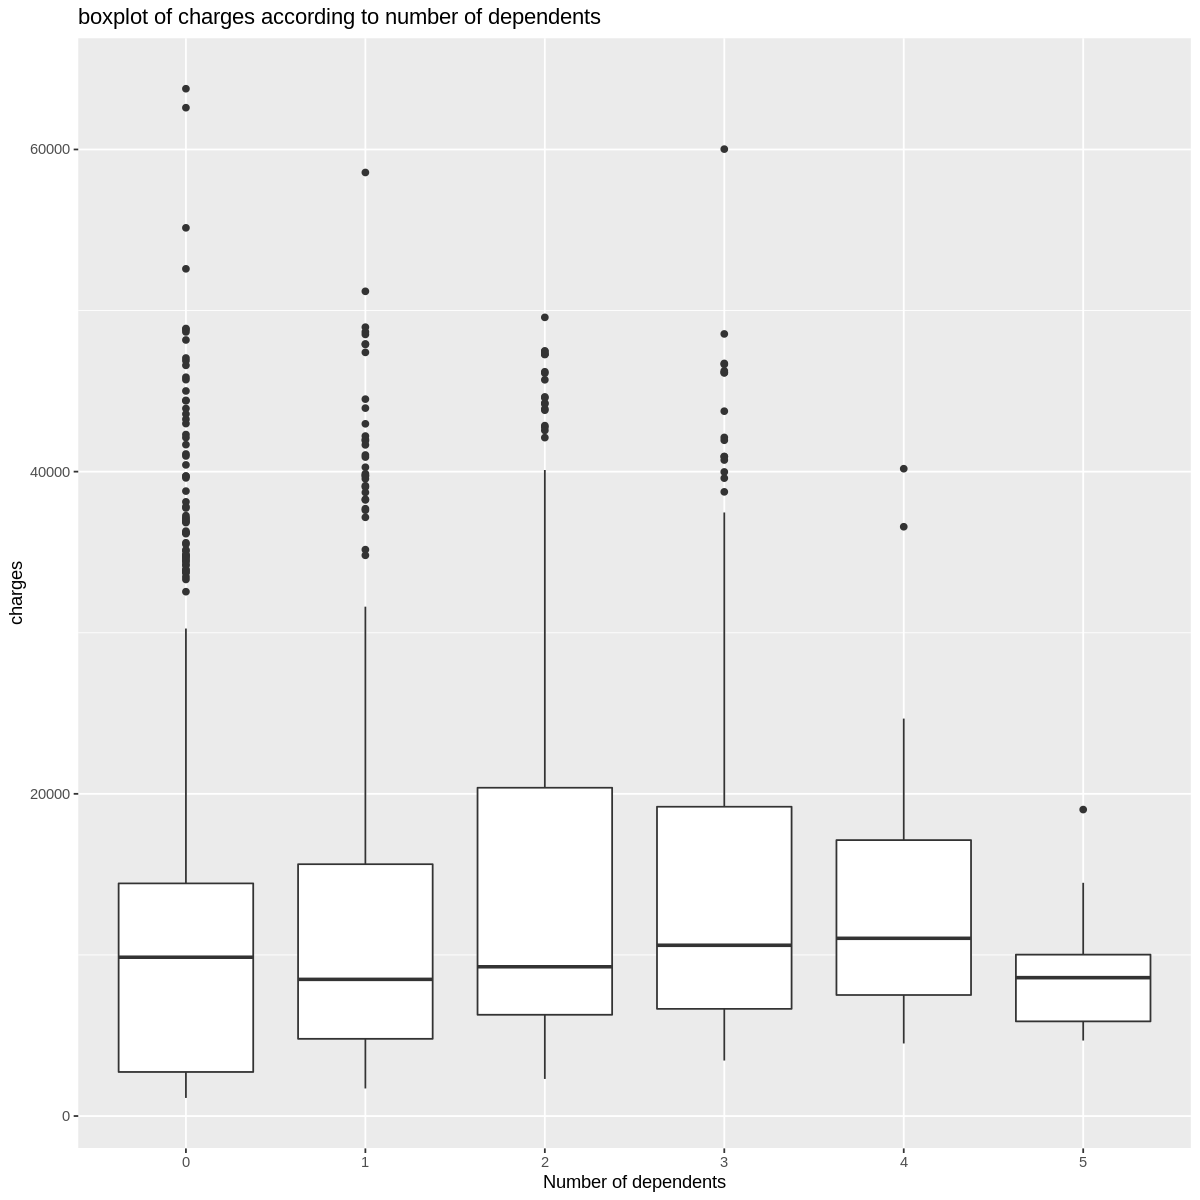

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot1 <- ggplot(insurance, aes(x=as.factor(children), y=charges)) +
    geom_boxplot() +
    ggtitle("boxplot of charges according to number of dependents") +
    xlab("Number of dependents")
plot1

*Figure 1: Boxplot of Charges Based on Number of Dependents*

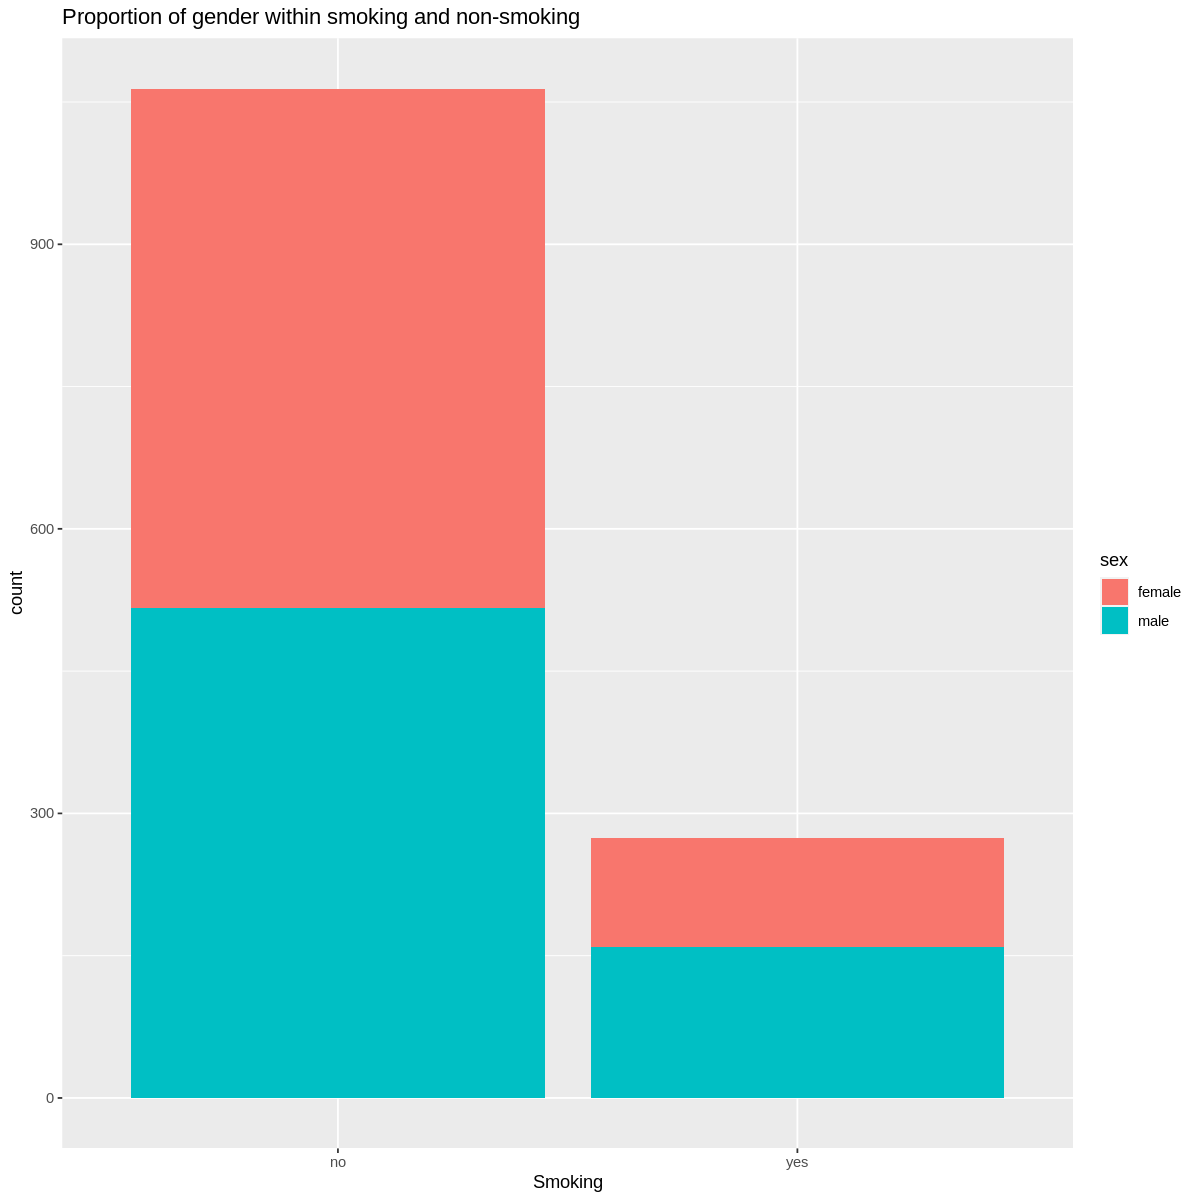

In [13]:
plot2 <- insurance %>%
    ggplot() +
    geom_bar(aes(x=as.factor(smoker), fill = sex)) +
    ggtitle("Proportion of gender within smoking and non-smoking") +
    xlab("Smoking")

plot2

*Figure 2: Bar Graph for the Gender Proportion in Smokers and Non-smokers*

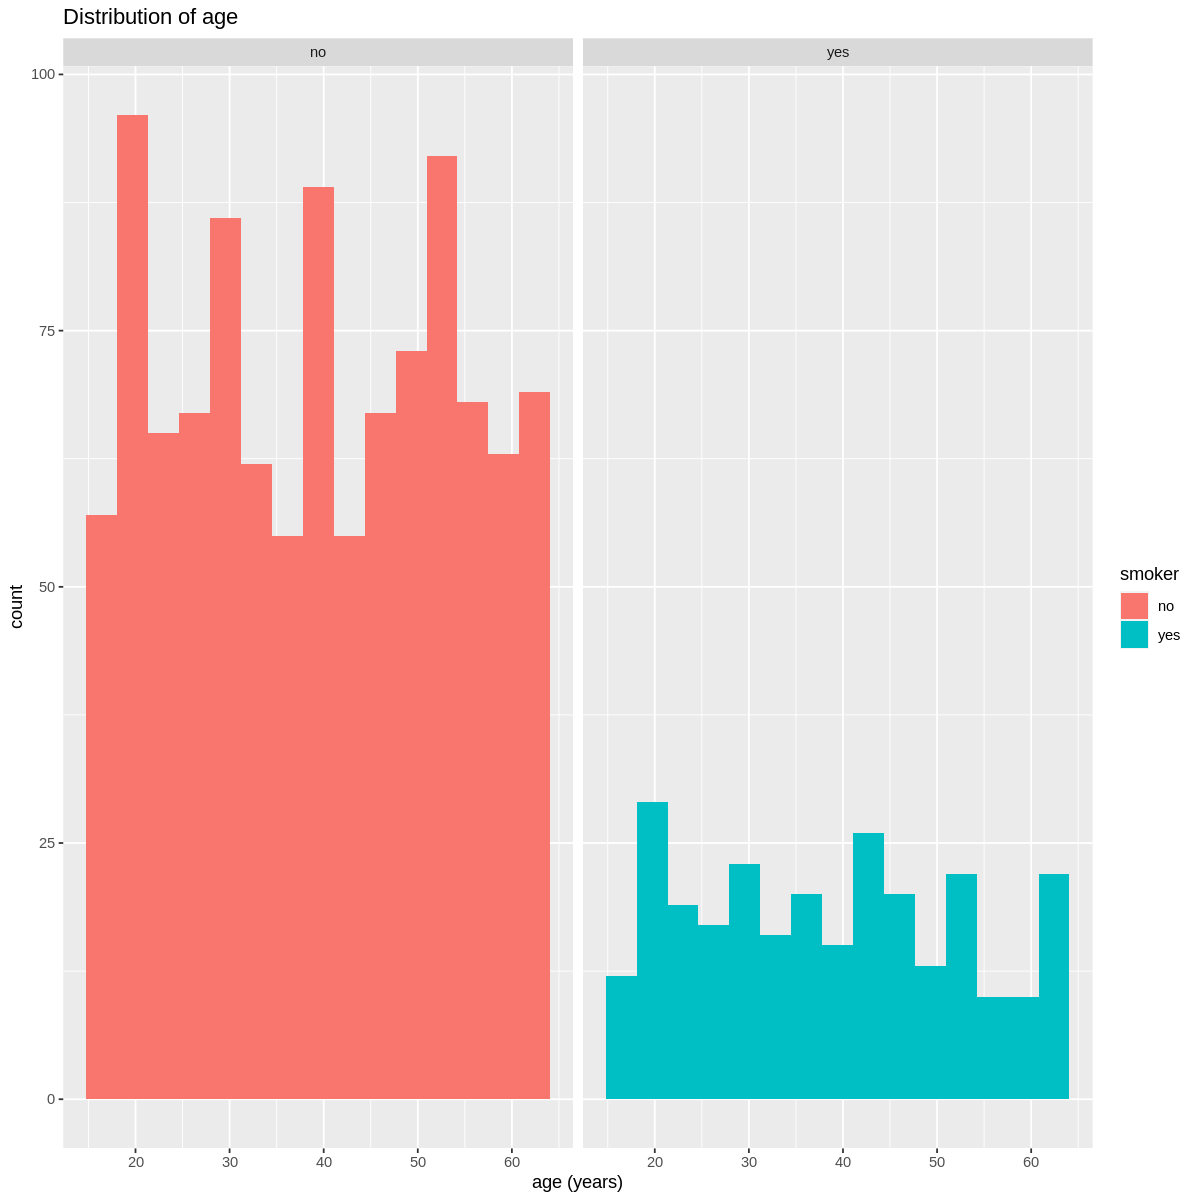

In [16]:
smoker_age_plot <- insurance %>%
    ggplot(aes(x = age, fill = smoker)) +
    geom_histogram(bins = 15) +
    facet_grid(.~ factor(smoker)) +
    ggtitle("Distribution of age") +
    xlab("age (years)") 

smoker_age_plot

*Figure 3: Distribution of Age Between Smokers and Non-Smokers*

Fortunately, the groups look like they are well represented in the smoking and non-smoking groups.

In [5]:
insurance_estimates <- insurance %>%
    group_by(smoker) %>%
    summarize(mean = mean(charges), sd = sd(charges)) 

insurance_estimates

smoker,mean,sd
<chr>,<dbl>,<dbl>
no,8434.268,5993.782
yes,32050.232,11541.547


*Figure 4: Mean and Standard Deviation of Smokers and Non-Smokers* 

We can see in Figure 4 that the mean charges for non-smokers is about $\$$8434 and the mean charges for smokers is $\$$32050, with the standard deviations being $\$$5994 and $\$$11542 respectively. Assesing these initial values, the mean insurance charges of smokers are higher than those of non-smokers, although the standard deviation is much higher so it is possible the real difference in charges is much closer.

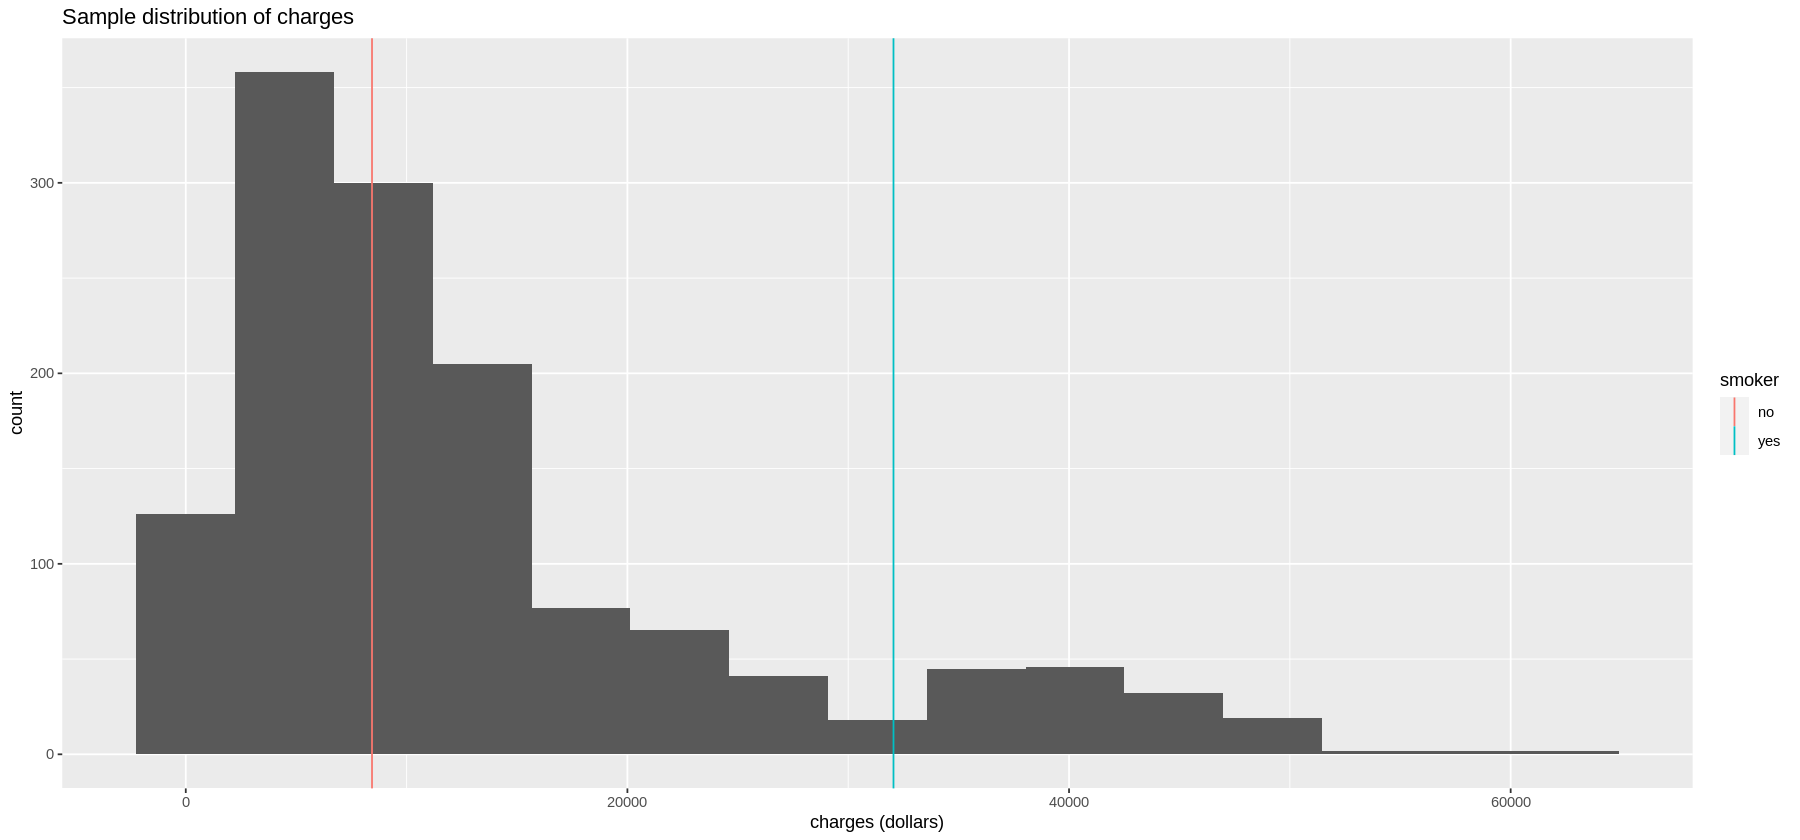

In [6]:
options(repr.plot.width=15, repr.plot.height=7) 

plot5 <- insurance %>%
    ggplot(aes(x = charges)) +
    geom_histogram(bins = 15) +
    ggtitle("Sample distribution of charges") +
    xlab("charges (dollars)") +
    geom_vline(data = insurance_estimates, aes(xintercept = mean, color = smoker)) 
plot5

*Figure 5: Sample Distribution of Charges With Vertical Lines Indicating the Mean of Each Group*

In [7]:
# select smoker and charges columns from our dataset
insurance <- insurance %>%
    select(smoker, charges) %>%
    filter(!is.na(charges))

#view filtered dataset
head(insurance)

smoker,charges
<chr>,<dbl>
yes,16884.924
no,1725.552
no,4449.462
no,21984.471
no,3866.855
no,3756.622


### Methods Plan
To answer the question, we will conduct a hypothesis test using the difference in means between yearly insurance charges of smokers versus non-smokers in the United States as our point estimate. We will set a seed whenever we use randomization to ensure our code is reproducible.

$$H_0: \mu_{\text{smokers}} - \mu_{\text{non-smokers}}=0$$

$$H_1:\mu_{\text{smokers}} - \mu_{\text{non-smokers}}>0$$


Since the smoker and non-smoker groups are independent and the distribution is not normal, we will use the following two-sample t-test;


$$
T = \frac{\bar{x}_{\text{smokers}} - \bar{x}_{\text{non-smokers}}}{\sqrt{\frac{s^2_{\text{smokers}}}{n_1}+\frac{s^2_{\text{non-smokers}}}{n_2}}}
$$

We will also use the permutation method to generate the null distribution to determine how unlikely it is to observe a statistic as extreme as the null hypothesis. 

Then we will calculate the p-value from both methods, which is the probability of how unusual the data results are if $H_0: \mu_{\text{smokers}} - \mu_{\text{non-smokers}}=0$ is true. We will assign a 5% significance level and compare our p-value against it to determine whether we should reject $H_0$.

We will then calculate the 95% confidence interval for our test statistic to get a better sense of the spread of the data.

Through this analysis, We expect to find that the people who smoke are charged more for health insurance than those who do not, which means that we expect to reject $H_0$. This would tell people that they can lower insurance costs based on their smoking habits. This study could also lead to further questions regarding if this analysis applies to other countries with different insurance laws and smoking levels.


While our expected result is to see a correlation between insurance costs and smoking status, there are many other factors impacting that impact these costs. As a result, we must be careful reporting a direct relationship when many other factors could also influence insurance charges, and our relatively small sample size could lead us to report a relationship that only exists for a small part of the population.

## Analysis


 ### Resampling method

 #### 1. obtain the observed test statistic

In [8]:
obs_stat <- insurance %>%
    specify(formula = charges ~ smoker)%>%
    calculate(stat="diff in means",order=c("yes","no"))%>%
    pull()

cat("The observed test statistic is",  obs_stat)

The observed test statistic is 23615.96

 #### 2. Use resampling method to simulate the null distribution

We generate a null distribution to obtain the probability of getting our test statistic under the assumption that the null hypothesis is true. We generate 1000 reps because the sample is very large and this operation becomes very slow if we use many more.

In [9]:
set.seed(12345)

insurance_null <- insurance %>%
    specify(formula = charges ~ smoker)%>%
    hypothesize(null="independence")%>%
    generate(reps=1000, type = "permute")%>%
    calculate(stat="diff in means",order=c("yes","no"))

head(insurance_null)

replicate,stat
<int>,<dbl>
1,-598.7382
2,347.7493
3,770.4276
4,-982.4877
5,-1257.8037
6,-484.6876


 #### 3. visualize the null distribution and p value

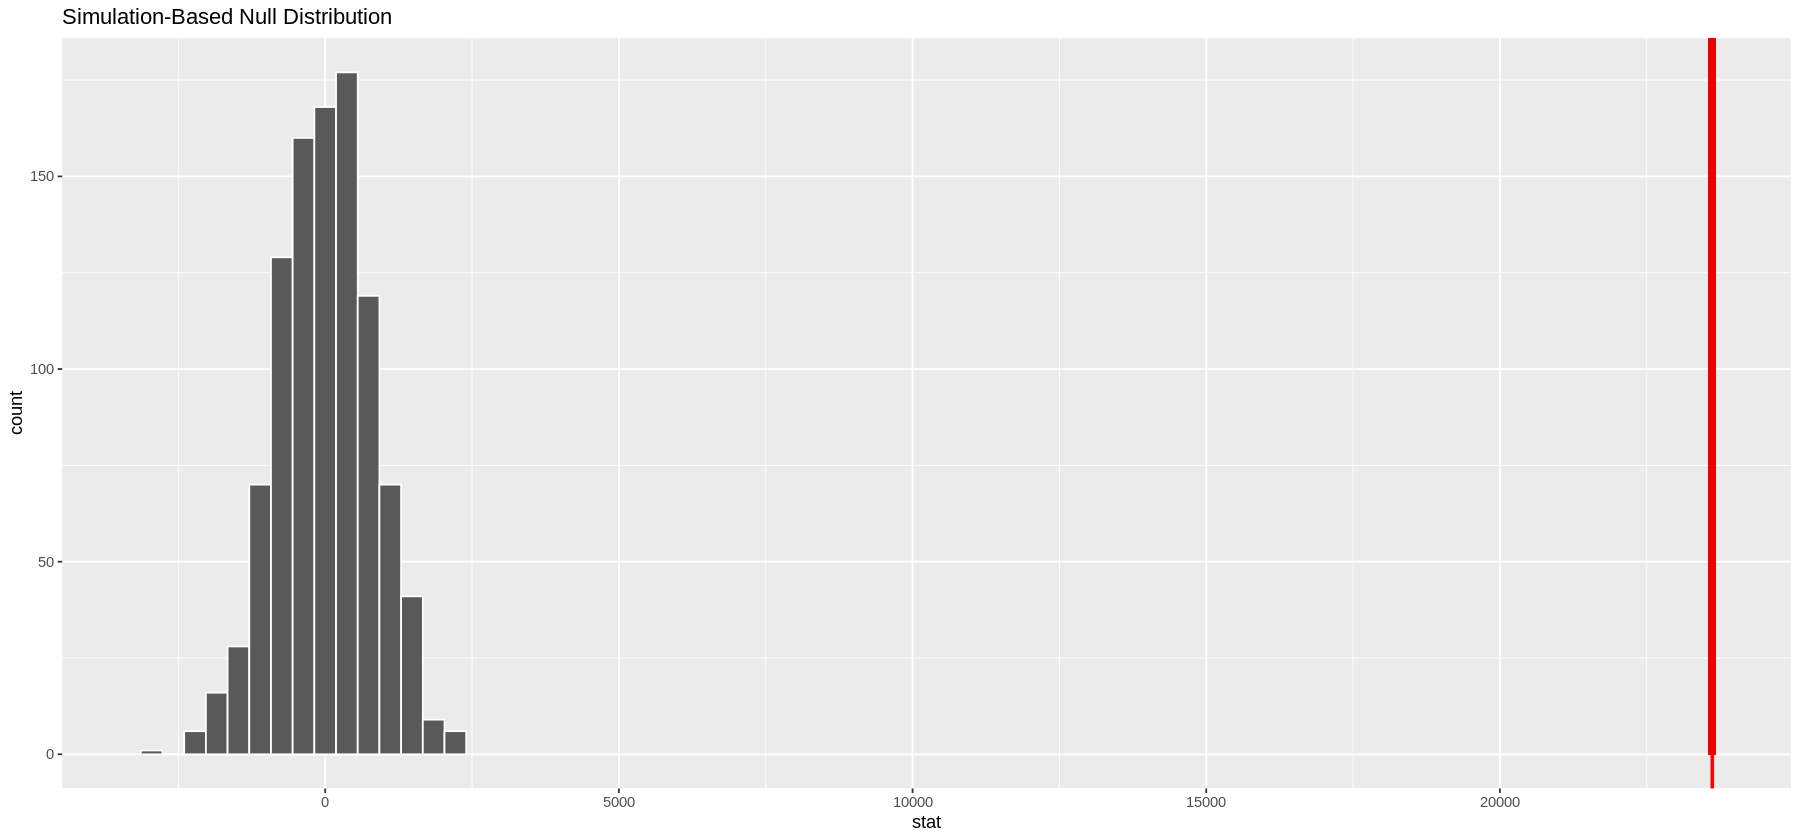

In [51]:
null_distribution_plot <- insurance_null %>%
    visualize() +
    geom_vline(xintercept = obs_stat, col = "red", size = 1) +
    shade_p_value(obs_stat = obs_stat, direction = "right")

null_distribution_plot

#### 4. get the p-value

In [12]:
p_value <- insurance_null %>%
 get_p_value(obs_stat = obs_stat, direction = "right")

p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


Our p-value is 0. In other words, the probability of us producing a sample with a statistic that is equal to the null hypothesis practically 0% (It is not actually exactly 0 but it is reported as such due to the mathematical limitations of the above method).

### Asymptotic Method

Next we conduct a t test to calculate the p-value using asymptotics. We do this because the size of the sample n is sufficiently large to use the t test statistic, and we do not have access to the populations standard deviation to use the z statistic. The default confidence level of the test is 0.95. 

In [13]:
asymptotic <- 
    broom::tidy(
        t.test(x = filter(insurance, smoker == "yes")$charges,
               y = filter(insurance, smoker == "no")$charges,
               alternative = "greater"))
asymptotic

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
23615.96,32050.23,8434.268,32.75189,2.944732e-103,311.8511,22426.4,Inf,Welch Two Sample t-test,greater


Our asymptotic method also gives us a very small p-value and is consistent with our resampling method. Our asymptotic methods tells us that under our null model there is a probability of 2.944732e-103 to produce a sample with a statistic that is either equal or more exteme than our null hypothesis.

In [14]:
mean_diff_in_charges_ci <- 
    tibble(
        lower_ci = asymptotic$conf.low,
        upper_ci = asymptotic$conf.high
        )

mean_diff_in_charges_ci

lower_ci,upper_ci
<dbl>,<dbl>
22426.4,Inf


Do you think one of bootstrapping or asymptotics is more appropriate than the other? Why or why not? Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.

When doing asymptotics we need to make sure that our sample satisfies several assumptions whereas a resampling approach doesn't require any assumptions about the underlying distribution of our population. Furthermore, our sample must be representative of the population for both methods to be effective. However, we found from our preliminary data analysis that our data satisfies the assumptions necessary for asymptotics. Hence for our particular problem, there should not be one method that is more appropriate than the other. However due to the extremely small p-value observed, our asymptotics method is more appropriate and reliable because it returned a concrete value. Although the reshuffling method returned a p-value of 0, this does not tell us much as it is impossible to tell which is the largest significance level for which the null hypothesis would be rejected.

## Discussion

Summarize what you found, and the implications/impact of your findings.


If relevant, discuss whether your results were what you expected to find.

Discuss future questions/research this study could lead to.


From our hypothesis test, we found that our p-value is less than 0.001 (2.944732e-103 to be precise) which is much lower than our 5% significance level, hence we have strong evidence to reject the null hypothesis. From our t-test, we found the 95% confidence interval of 22426.4 to infinite, telling us we are 95% confident the true difference in means is some number greater than 22426.4. The combination of low p-value and this confidence interval makes us fairly confident in our rejection of our null hypothesis, and using a 5% significance level, the probability of us commiting type one error and wrongly rejecting the null hypothesis is only 5%. 

This suggests that the true mean of yearly health insurance charges of smokers is much higher than the true mean charges of non-smokers. This aligns with what we expected from our preliminary data analysis where we found that the sample mean charges of smokers is higher than the sample mean charges of non-smokers. This result suggests that smokers will be charged more for health insurance than non-smokers, a fact that makes sense given the well researched negative health impacts smoking can have.

The impacts of these findings could be significant for people looking to lower their insurance costs. Seeing that people who smoke pay over $20,000 per year more than people who don't could motivate people to stay away from or quit smoking, allowing them to not only stay healthier but cut insurance costs in doing so.

Further studies could look into the relationship bewteen smoking and other variables such as gender, income, occupation, etc, that were not explored in this analysis, to determine if there are any other factors with a greater impact on health insurance costs than smoking. Although we tried to ensure there was no codependence in our dataset, it is impossible to know for certain if this was the case without further research. 




## References

Datta, A. (2019) <i>US Health Insurance Dataset</i> [Data set]. Kaggle. https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset

Keisler-Starkey, K., & Bunch, L.N. (2022, September 13). <i>Health Insurance Coverage in the United States: 2021</i>. United States Census Bureau.     
    https://www.census.gov/library/publications/2022/demo/p60-278.html#:~:text=Highlights,8.6%20percent%20or%2028.3%20million

Fontinelle, A. (2022, March 2). <i>How Much Does Health Insurance Cost?</i>. Investopedia. 
    https://www.investopedia.com/how-much-does-health-insurance-cost-4774184